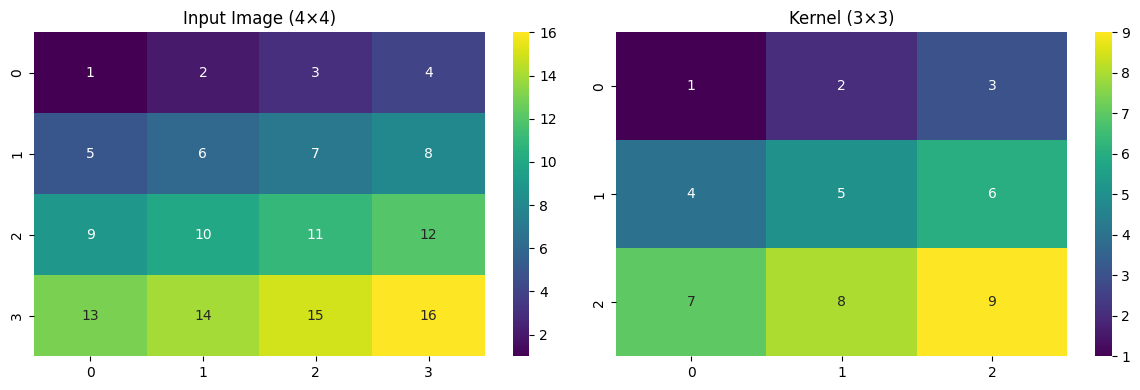


Output position (0,0):
Input patch:
tensor([[ 1.,  2.,  3.],
        [ 5.,  6.,  7.],
        [ 9., 10., 11.]])

Kernel:
tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

Element-wise multiplication:
tensor([[ 1.,  4.,  9.],
        [20., 30., 42.],
        [63., 80., 99.]])
Sum (output value): 348.0

Output position (0,1):
Input patch:
tensor([[ 2.,  3.,  4.],
        [ 6.,  7.,  8.],
        [10., 11., 12.]])

Kernel:
tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

Element-wise multiplication:
tensor([[  2.,   6.,  12.],
        [ 24.,  35.,  48.],
        [ 70.,  88., 108.]])
Sum (output value): 393.0

Output position (1,0):
Input patch:
tensor([[ 5.,  6.,  7.],
        [ 9., 10., 11.],
        [13., 14., 15.]])

Kernel:
tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

Element-wise multiplication:
tensor([[  5.,  12.,  21.],
        [ 36.,  50.,  66.],
        [ 91., 112., 135.]])
Sum (output value): 528.0

Output position (1

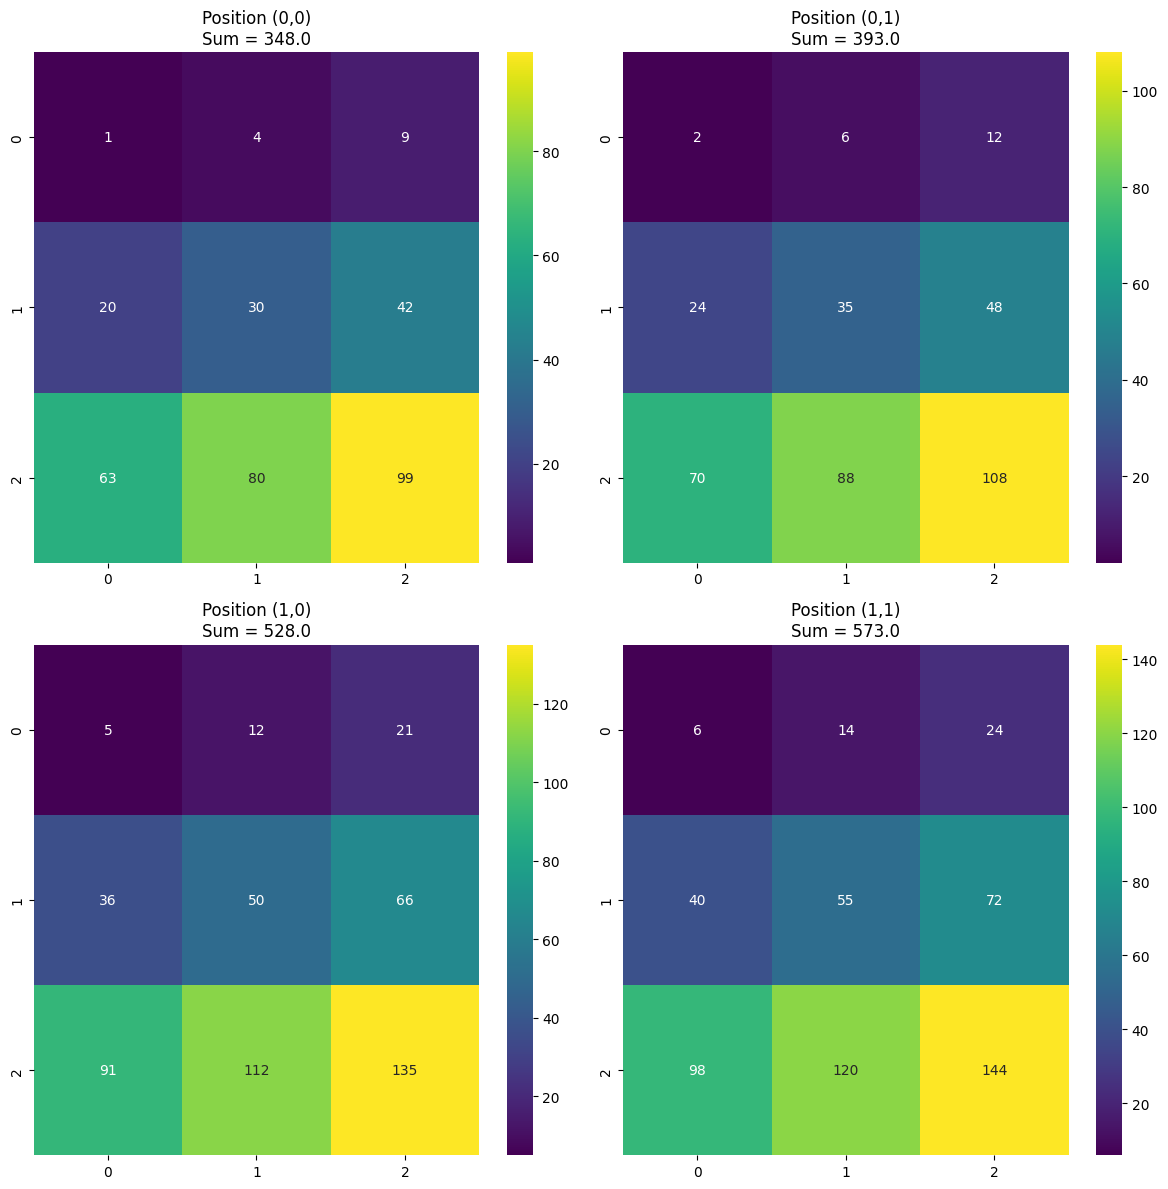

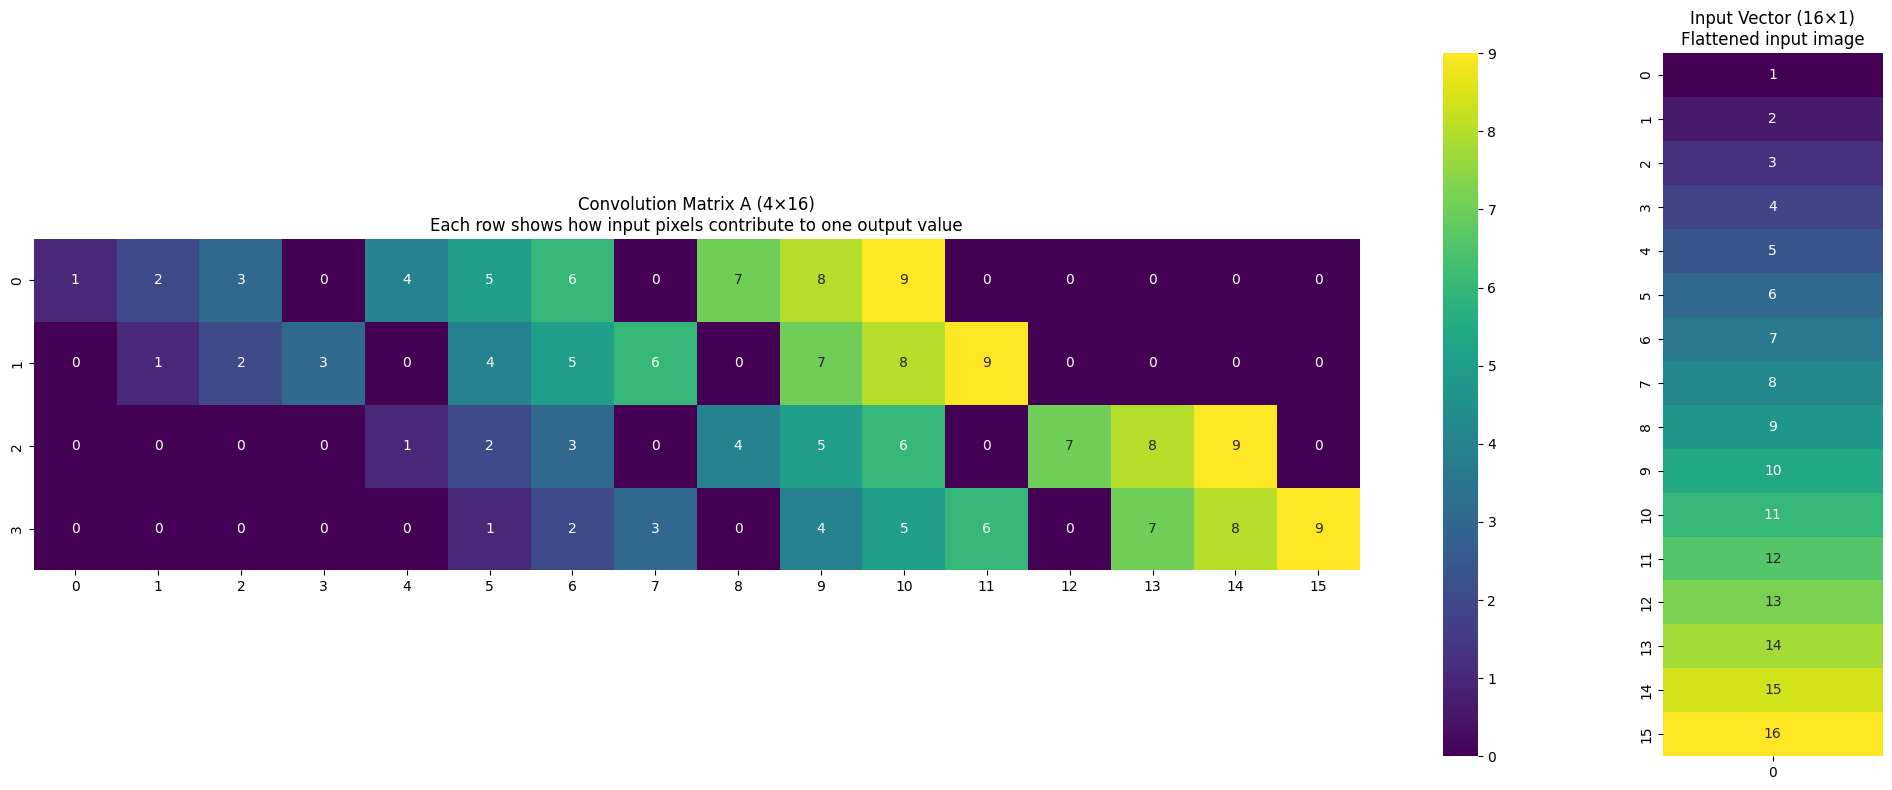

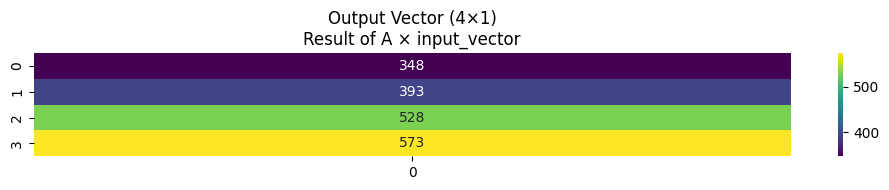

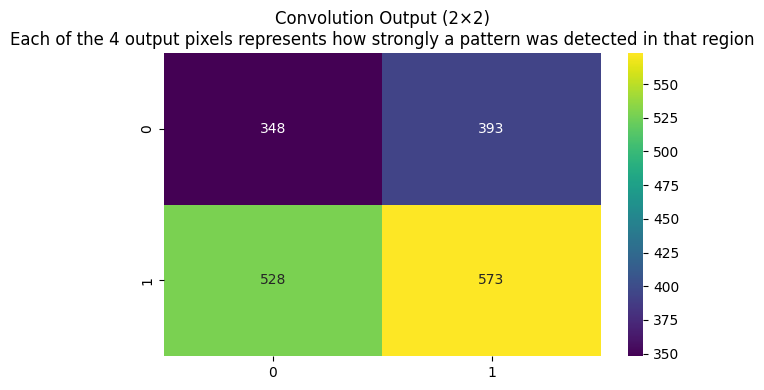

In [67]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------------
# 1) "Image"  (4 × 4)   and   Kernel  (3 × 3)
# This is a 4x4 input image tensor where values increase sequentially from 1 to 16
# Each number represents a pixel intensity value in the input image
# The values increase from top-left (1) to bottom-right (16)
v_img = torch.tensor([[1,  2,  3,  4],
                      [5,  6,  7,  8],
                      [9, 10, 11, 12],
                      [13,14, 15, 16]], dtype=torch.float32)

# This kernel represents a 3x3 filter where values increase from 1 to 9
# Each number represents a weight that will be multiplied with corresponding input pixels
# The pattern shows increasing values from top-left (1) to bottom-right (9)
kernel = torch.tensor([[1, 2, 3],
                       [4, 5, 6],
                       [7, 8, 9]], dtype=torch.float32)

# Visualize input image and kernel
plt.figure(figsize=(12, 4))
plt.subplot(121)
sns.heatmap(v_img.numpy(), annot=True, cmap='viridis', fmt='.0f')
plt.title('Input Image (4×4)')
plt.subplot(122)
sns.heatmap(kernel.numpy(), annot=True, cmap='viridis', fmt='.0f')
plt.title('Kernel (3×3)')
plt.tight_layout()
plt.show()

# Reshape input image to (batch, channels, height, width) format
# Reshape kernel to (out_channels, in_channels, height, width) format
# out_channels: number of filters/kernels (1 in this case)
# in_channels: number of input channels (1 in this case since it's grayscale)
v_bchw = v_img.unsqueeze(0).unsqueeze(0)      # (1,1,4,4)
w_oihw = kernel.unsqueeze(0).unsqueeze(0)     # (1,1,3,3)

# Print and visualize the multiplications for each output position
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for idx, (i, j) in enumerate([(0,0), (0,1), (1,0), (1,1)]):
    # Get the 3x3 patch of input image
    patch = v_img[i:i+3, j:j+3]
    
    # Print the multiplication
    print(f"\nOutput position ({i},{j}):")
    print("Input patch:")
    print(patch)
    print("\nKernel:")
    print(kernel)
    print("\nElement-wise multiplication:")
    mult = patch * kernel
    print(mult)
    print(f"Sum (output value): {torch.sum(mult)}")
    
    # Visualize the multiplication
    ax = axes[idx]
    sns.heatmap(mult.numpy(), annot=True, cmap='viridis', fmt='.0f', ax=ax)
    ax.set_title(f'Position ({i},{j})\nSum = {torch.sum(mult)}')

plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 2) Build the explicit convolution matrix A  (4 × 16)
H, W = 4, 4          # Input image dimensions
out_h, out_w = 2, 2  # Output dimensions after convolution
A = torch.zeros(out_h * out_w, H * W)  # Create empty matrix (4×16)

# For each input pixel position p:
for p in range(H * W):
    delta = torch.zeros((1, 1, 4, 4))  # Explicit shape (batch, channel, height, width)
    # Convert 1D index p into 2D (row, column) coordinates by:
    # - row = p // W (integer division)
    # - col = p % W (modulo)
    r, c = divmod(p, W)
    delta[0, 0, r, c] = 1.0  # Set the single 1.0 at position (r,c)
    # This line computes how a single input pixel (at position p) contributes to all output values
    # 1. delta is a 4x4 matrix with a single 1.0 at position p
    # 2. F.conv2d applies the kernel w_oihw to this single-pixel input
    # 3. The result is flattened and stored in column p of matrix A
    # This builds one column of the convolution matrix A, showing how one input pixel affects all outputs
    conv_result = F.conv2d(delta, w_oihw).flatten()
    # print(f"Column {p}: Storing convolution result for input pixel at position ({r},{c})")
    # print(f"Convolution result: {conv_result}")
    A[:, p] = conv_result
# Visualize convolution matrix A and input vector side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), gridspec_kw={'width_ratios': [4, 1]})

# Plot convolution matrix A
sns.heatmap(A.numpy(), annot=True, cmap='viridis', fmt='.0f', ax=ax1, square=True)
ax1.set_title('Convolution Matrix A (4×16)\nEach row shows how input pixels contribute to one output value', fontsize=12)
ax1.set_aspect('equal')  # Force square cells

# Plot input vector as a column vector
v_flat = v_img.flatten()  # Flatten input image to vector
sns.heatmap(v_flat.reshape(-1, 1), annot=True, cmap='viridis', fmt='.0f', ax=ax2, cbar=False)
ax2.set_title('Input Vector (16×1)\nFlattened input image', fontsize=12)
ax2.set_aspect(0.2)  # Make the input vector visualization narrower

plt.tight_layout()
plt.show()

# Visualize the matrix multiplication result
y_from_A = A @ v_flat  # Matrix multiplication
plt.figure(figsize=(10, 2))
sns.heatmap(y_from_A.reshape(-1, 1), annot=True, cmap='viridis', fmt='.0f')
plt.title('Output Vector (4×1)\nResult of A × input_vector')
plt.tight_layout()
plt.show()

y_from_A = A @ v_flat     # Matrix multiplication
y_torch = F.conv2d(v_bchw, w_oihw, stride=1, padding=0)  # (1,1,2,2)
assert torch.allclose(y_from_A, y_torch.flatten())  # Should match direct convolution result

# Visualize the 2x2 output matrix from the convolution operation
# Each value represents the result of applying the 3x3 kernel to a 3x3 patch of the input image
plt.figure(figsize=(6, 4))
sns.heatmap(y_torch.squeeze().numpy(), annot=True, cmap='viridis', fmt='.0f')
plt.title('Convolution Output (2×2)\nEach of the 4 output pixels represents how strongly a pattern was detected in that region')
plt.tight_layout()
plt.show()

# What the model is trying to accomplish
# 
# Spatial Downsampling
# Going from 4×4 input → 2×2 output reduces spatial dimensions while preserving important features:
# Input: 16 pixels of raw data
# Output: 4 values of processed features
# More compact representation with learned features
#
# Local Pattern Recognition
# Each output pixel "summarizes" what the kernel detected in its receptive field:
# The kernel slides across the input
# Each position produces one output value
# Higher values = stronger pattern match
#
# For our toy example with a Bottom-Right heavy kernel:
# If the 3×3 kernel has its highest weights in the bottom-right, then this convolution is specifically looking for input regions where:
# The bottom-right pixels are bright/high values
# The pattern matches the kernel's weight distribution
# Each output pixel answers: "How much does this region of the input match my bottom-right-heavy pattern?"

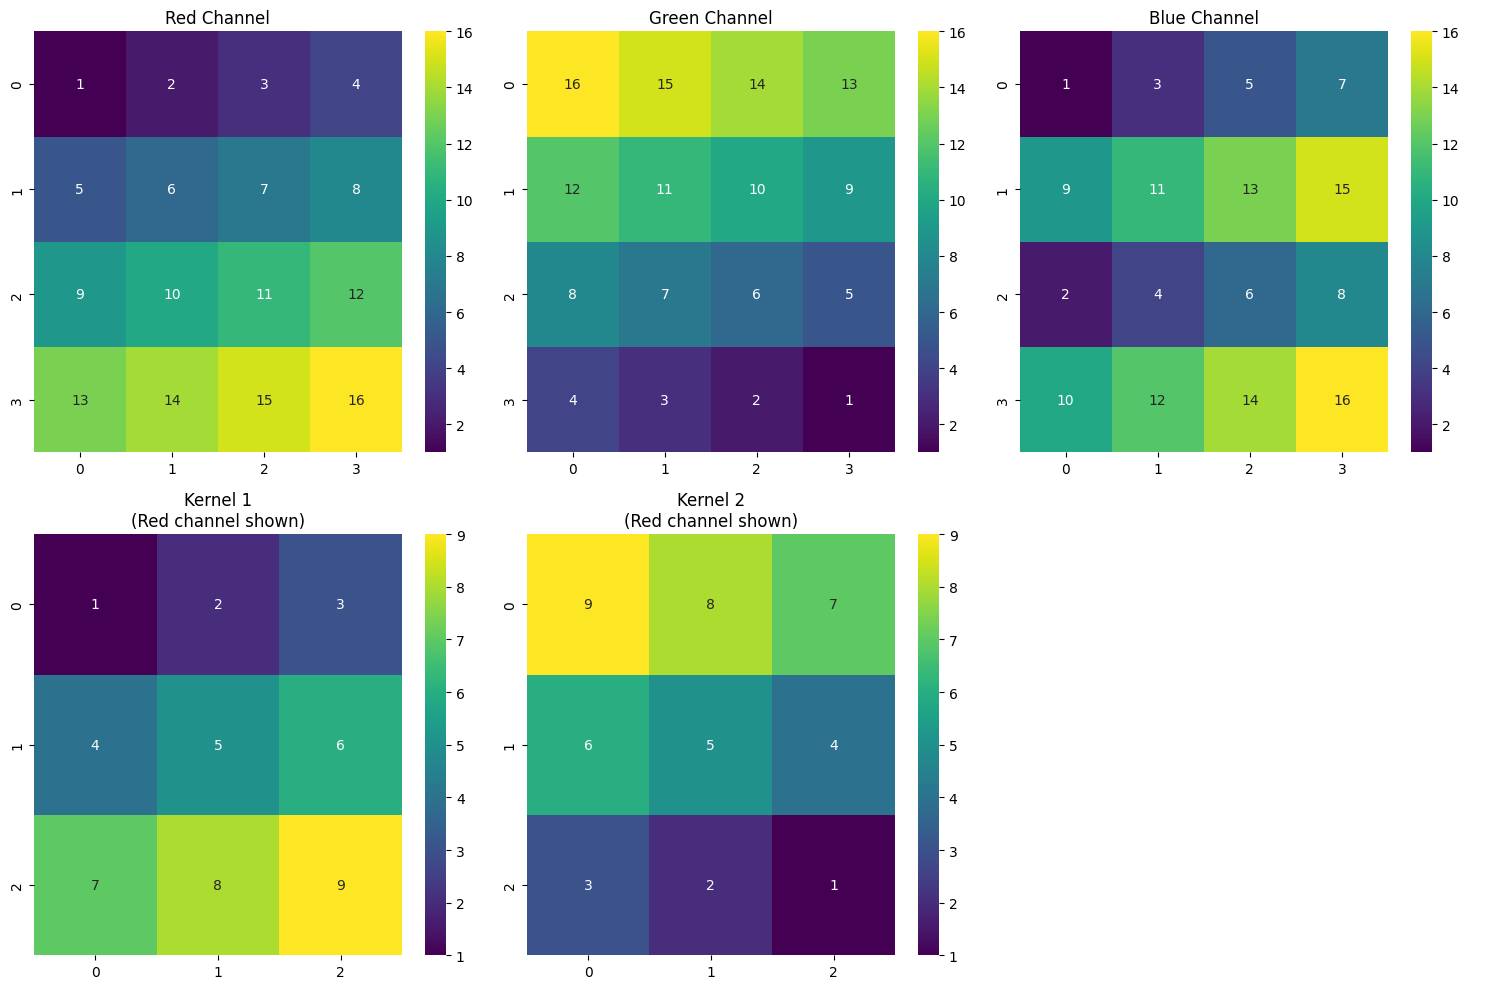

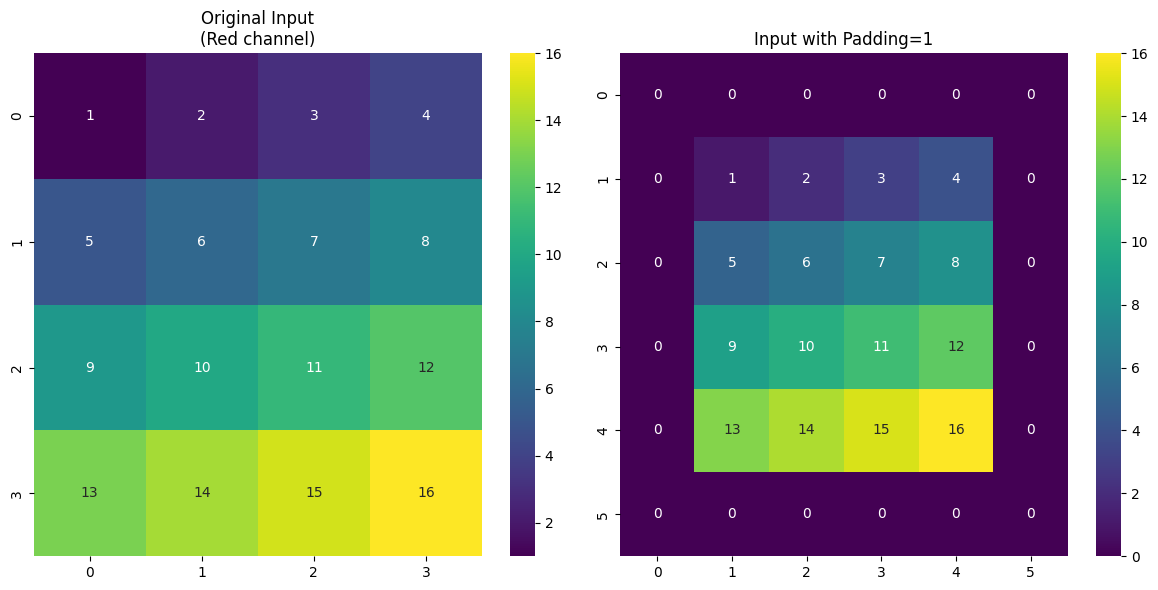

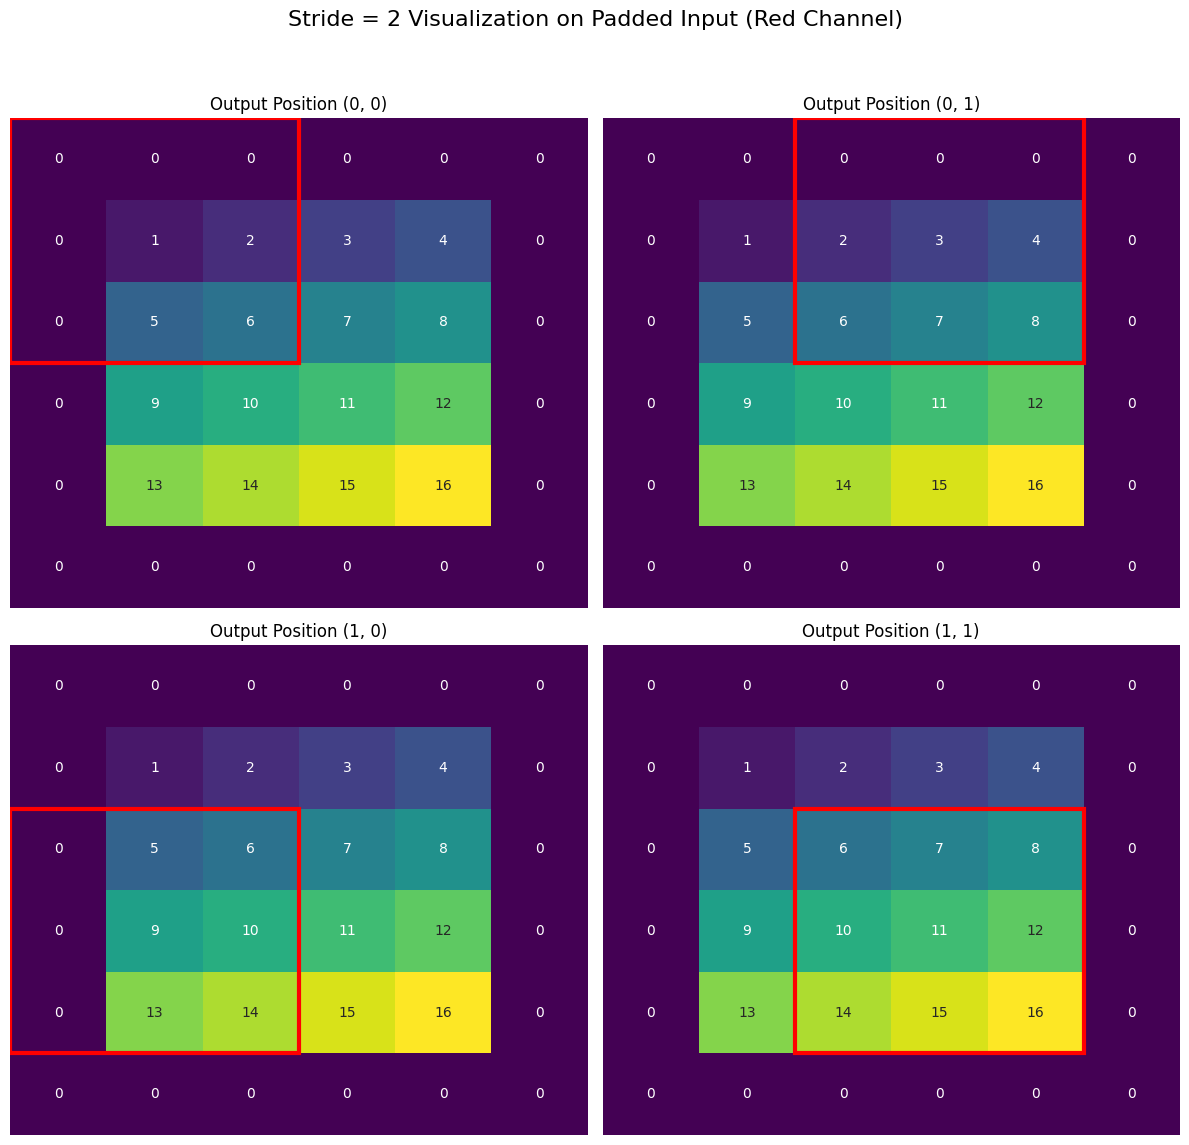


Detailed Convolution Calculations for All Feature Maps:


==================== Calculating Feature Map 1 ====================
Using Kernel 1 (shape: torch.Size([3, 3, 3]))

Output Position (0, 0):

--- Input Channel 0 ---
Input Region:
[[0. 0. 0.]
 [0. 1. 2.]
 [0. 5. 6.]]

Kernel Slice (for input channel 0):
[[1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 9.]]

Element-wise Multiplication:
[[ 0.  0.  0.]
 [ 0.  5. 12.]
 [ 0. 40. 54.]]

Channel Sum: 111.0

--- Input Channel 1 ---
Input Region:
[[ 0.  0.  0.]
 [ 0. 16. 15.]
 [ 0. 12. 11.]]

Kernel Slice (for input channel 1):
[[9. 8. 7.]
 [6. 5. 4.]
 [3. 2. 1.]]

Element-wise Multiplication:
[[ 0.  0.  0.]
 [ 0. 80. 60.]
 [ 0. 24. 11.]]

Channel Sum: 175.0

--- Input Channel 2 ---
Input Region:
[[ 0.  0.  0.]
 [ 0.  1.  3.]
 [ 0.  9. 11.]]

Kernel Slice (for input channel 2):
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]

Element-wise Multiplication:
[[ 0.  0.  0.]
 [ 0.  1.  3.]
 [ 0.  9. 11.]]

Channel Sum: 24.0

>>> Final value at Output Position (0, 0) for 

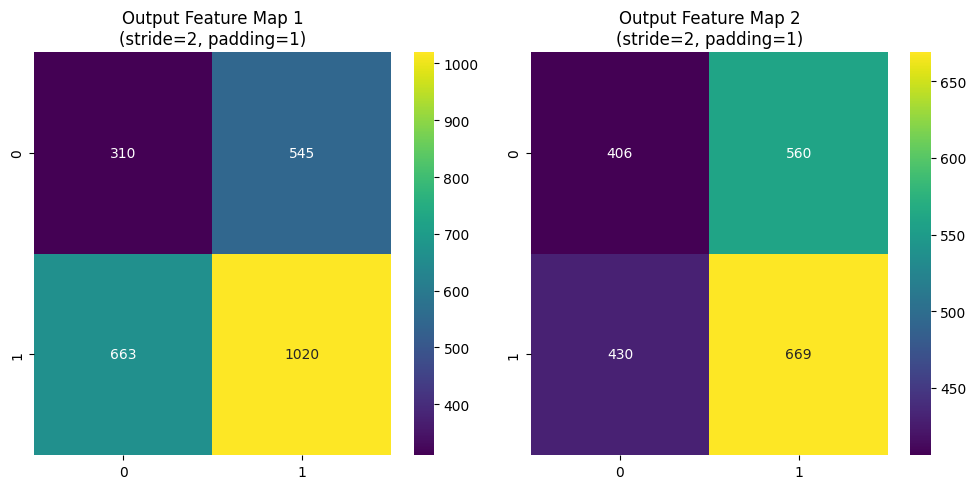


Convolution Details:
Input shape: torch.Size([1, 3, 4, 4])
Kernels shape: torch.Size([2, 3, 3, 3])
Output shape: torch.Size([1, 2, 2, 2])
Stride: 2
Padding: 1
y_torch:  tensor([ 310.,  545.,  663., 1020.,  406.,  560.,  430.,  669.])


In [69]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------------
# 1) Multi-channel input image (4×4×3) and multiple kernels (2×3×3×3)
# Create a 4x4 RGB image with 3 channels
v_img = torch.stack([
    torch.tensor([[1,  2,  3,  4],    # Red channel
                 [5,  6,  7,  8],
                 [9, 10, 11, 12],
                 [13,14, 15, 16]], dtype=torch.float32),
    torch.tensor([[16,15,14,13],      # Green channel
                 [12,11,10, 9],
                 [8,  7,  6,  5],
                 [4,  3,  2,  1]], dtype=torch.float32),
    torch.tensor([[1,  3,  5,  7],    # Blue channel
                 [9, 11,13,15],
                 [2,  4,  6,  8],
                 [10,12,14,16]], dtype=torch.float32)
])

# Create two different 3x3 kernels for each input channel
kernel1 = torch.stack([
    torch.tensor([[1, 2, 3],           # Kernel 1 for Red channel
                 [4, 5, 6],
                 [7, 8, 9]], dtype=torch.float32),
    torch.tensor([[9, 8, 7],           # Kernel 1 for Green channel
                 [6, 5, 4],
                 [3, 2, 1]], dtype=torch.float32),
    torch.tensor([[1, 1, 1],           # Kernel 1 for Blue channel
                 [1, 1, 1],
                 [1, 1, 1]], dtype=torch.float32)
])

kernel2 = torch.stack([
    torch.tensor([[9, 8, 7],           # Kernel 2 for Red channel
                 [6, 5, 4],
                 [3, 2, 1]], dtype=torch.float32),
    torch.tensor([[1, 2, 3],           # Kernel 2 for Green channel
                 [4, 5, 6],
                 [7, 8, 9]], dtype=torch.float32),
    torch.tensor([[1, 0, 1],           # Kernel 2 for Blue channel
                 [0, 1, 0],
                 [1, 0, 1]], dtype=torch.float32)
])

# What would these dummy kernels be looking for?
# Kernel 1
#  Patches where the red channel is brighter toward the bottom-right and the green channel is brighter toward the top-left.
#  Blue contributes a constant sum, so it mostly shifts the score but doesn’t decide sign.
# Hence in the 2 × 2 activation you’ll see a large positive response at positions whose 3 × 3 RGB cube matches that “red-down / green-up” correlation; other positions will score lower or even negative.

# Kernel 2
#  Red and green roles are swapped relative to kernel 1.
#  Blue slice is a ✕-shaped mask (weights only on the diagonals).
# So feature-map 2 lights up where red is high top-left / green high bottom-right / blue has a diagonal highlight.

# If you trained on natural images instead of hand-coding two stacks, and expanded to 64 output channels, 64 filter-stacks would specialise:
#  Some become oriented‐edge detectors (e.g., horizontal red-green contrast).
#  Some pick up colour opponents (e.g., “lots of yellow here”).
#  Some capture simple textures (checkerboards, dots).

# Because we used stride = 2, each activation also acts as a down-sampled summary of a 3 × 3 neighbourhood, so later layers operate on half the width/height but with richer channel information.

# Weights carry the learned patterns.
# Activations are correlations between those patterns and the current input patches.
# With 64 output channels you get a 64-way stack of such correlation maps, shape (1, 64, 2, 2).
# Subsequent layers read those maps (often after a non-linearity) and learn new kernels that combine them into even-more-abstract features.

# Visualize input channels and kernels
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, (ax, title) in enumerate(zip(axes[0], ['Red Channel', 'Green Channel', 'Blue Channel'])):
    sns.heatmap(v_img[i].numpy(), annot=True, cmap='viridis', fmt='.0f', ax=ax)
    ax.set_title(title)

for i, (ax, title) in enumerate(zip(axes[1], ['Kernel 1', 'Kernel 2', ''])):
    if i < 2:
        # Show first channel of each kernel as example
        sns.heatmap(kernel1[0].numpy() if i == 0 else kernel2[0].numpy(), 
                   annot=True, cmap='viridis', fmt='.0f', ax=ax)
        ax.set_title(f'{title}\n(Red channel shown)')
    else:
        ax.axis('off')
plt.tight_layout()
plt.show()

# Reshape for convolution
v_bchw = v_img.unsqueeze(0)                    # Add batch dimension (1,3,4,4)
w_oihw = torch.stack([kernel1, kernel2])       # (2,3,3,3)

# Configure convolution parameters
stride = 2
padding = 1
# Visualize padding
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original input
sns.heatmap(v_img[0].numpy(), annot=True, cmap='viridis', fmt='.0f', ax=axes[0])
axes[0].set_title('Original Input\n(Red channel)')

# Input with padding
padded = F.pad(v_img[0].unsqueeze(0).unsqueeze(0), (padding, padding, padding, padding), mode='constant', value=0)
sns.heatmap(padded[0,0].numpy(), annot=True, cmap='viridis', fmt='.0f', ax=axes[1])
axes[1].set_title(f'Input with Padding={padding}')

plt.tight_layout()
plt.show()

# Visualize stride effect
# The output size is (H_out, W_out) where:
# H_out = floor((H_in + 2*padding - H_kernel) / stride) + 1
# W_out = floor((W_in + 2*padding - W_kernel) / stride) + 1
# For our example:
# H_out = floor((4 + 2*1 - 3) / 2) + 1 = floor(3/2) + 1 = 1 + 1 = 2
# W_out = floor((4 + 2*1 - 3) / 2) + 1 = floor(3/2) + 1 = 1 + 1 = 2
# The output will be 2x2. Let's visualize the 4 positions the kernel is applied to.

output_h = ((v_img.shape[1] + 2 * padding - kernel1.shape[1]) // stride) + 1
output_w = ((v_img.shape[2] + 2 * padding - kernel1.shape[2]) // stride) + 1

fig, axes = plt.subplots(output_h, output_w, figsize=(12, 12))
# Use the same padded input from the previous visualization
padded_input = F.pad(v_img[0], (padding, padding, padding, padding), 'constant', 0)

for i in range(output_h):
    for j in range(output_w):
        ax = axes[i, j]
        sns.heatmap(padded_input.numpy(), annot=True, cmap='viridis', fmt='.0f', ax=ax, cbar=False)
        
        # Calculate top-left corner of the kernel application based on stride
        start_row = i * stride
        start_col = j * stride
        
        # Draw a rectangle to highlight the kernel's position
        rect = plt.Rectangle((start_col, start_row), kernel1.shape[2], kernel1.shape[1], 
                             linewidth=3, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        
        ax.set_title(f'Output Position ({i}, {j})')
        ax.set_xticks([])
        ax.set_yticks([])

plt.suptitle(f'Stride = {stride} Visualization on Padded Input (Red Channel)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
plt.show()

# Calculate and visualize each multiplication for all feature maps
print("\nDetailed Convolution Calculations for All Feature Maps:")

# Pad the input image across all channels
padded_v_img = F.pad(v_img, (padding, padding, padding, padding), mode='constant', value=0)
padded_input_numpy = padded_v_img.numpy()

# Get dimensions from the weight tensor
num_output_channels = w_oihw.shape[0] # gives the number of output channels (i.e., the number of kernels/filters).
num_input_channels = w_oihw.shape[1] # gives the number of input channels (i.e., the number of channels in the input image).
kernel_h, kernel_w = w_oihw.shape[2], w_oihw.shape[3] # gives the height and width of the kernel/filter.

# Iterate over each kernel to calculate each output feature map
for k in range(num_output_channels):
    kernel = w_oihw[k]  # This kernel has shape (C_in, K_h, K_w)
    kernel_numpy = kernel.numpy()
    
    print(f"\n\n{'='*20} Calculating Feature Map {k+1} {'='*20}")
    print(f"Using Kernel {k+1} (shape: {kernel.shape})")

    # For each position in the output feature map
    for i in range(output_h):
        for j in range(output_w):
            print(f"\nOutput Position ({i}, {j}):")
            
            # Calculate the region of interest
            start_row = i * stride
            end_row = start_row + kernel_h
            start_col = j * stride
            end_col = start_col + kernel_w
            
            # Process each input channel against the corresponding kernel slice
            channel_sums = []
            for c in range(num_input_channels):
                print(f"\n--- Input Channel {c} ---")
                
                # Get region for this channel from the padded input
                region = padded_input_numpy[c, start_row:end_row, start_col:end_col]
                
                # Get the corresponding slice from the current kernel
                kernel_slice = kernel_numpy[c]
                
                print("Input Region:")
                print(region)
                
                print(f"\nKernel Slice (for input channel {c}):")
                print(kernel_slice)
                
                # Calculate and print the element-wise multiplication
                mult = region * kernel_slice
                print("\nElement-wise Multiplication:")
                print(mult)
                
                # Store the sum for this channel
                channel_sum = np.sum(mult)
                channel_sums.append(channel_sum)
                print(f"\nChannel Sum: {channel_sum}")
            
            # The final output value is the sum of results from all channels
            final_value = sum(channel_sums)
            print(f"\n>>> Final value at Output Position ({i}, {j}) for Feature Map {k+1}: {final_value}")
            print("-" * 50)

# Perform convolution
y_torch = F.conv2d(v_bchw, w_oihw, stride=stride, padding=padding)  # (1,2,2,2)

# Visualize output feature maps
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i, ax in enumerate(axes):
    sns.heatmap(y_torch[0,i].numpy(), annot=True, cmap='viridis', fmt='.0f', ax=ax)
    ax.set_title(f'Output Feature Map {i+1}\n(stride={stride}, padding={padding})')
plt.tight_layout()
plt.show()

# Print convolution details
print(f"\nConvolution Details:")
print(f"Input shape: {v_bchw.shape}")
print(f"Kernels shape: {w_oihw.shape}")
print(f"Output shape: {y_torch.shape}")
print(f"Stride: {stride}")
print(f"Padding: {padding}")
print("y_torch: ", y_torch.flatten())

# What the model is trying to accomplish
# 
# Multi-channel Processing
# - Each kernel processes all input channels
# - Different kernels learn different features
# - Output channels represent different detected patterns
#
# Stride and Padding Effects
# - Stride > 1: Reduces spatial dimensions more aggressively
# - Padding > 0: Preserves spatial dimensions at edges
# - Output size = ((H + 2P - K) // S + 1, (W + 2P - K) // S + 1)
#   Example output size = ((4 + 2*1 - 3) // 2 + 1, (4 + 2*1 - 3) // 2 + 1) = (2, 2)
#   where H=4 (input height), W=4 (input width), P=1 (padding), K=3 (kernel size), S=2 (stride)
#
# Feature Learning
# - Each kernel learns to detect specific patterns
# - Multiple kernels allow detection of different features
# - Output channels can be thought of as different "views" of the input

Input Tensor Shape: torch.Size([1, 2, 4, 4])
Input Tensor:
Channel 1:
[[ 1.  2.  3.  4.]
 [ 5.  6.  7.  8.]
 [ 9. 10. 11. 12.]
 [13. 14. 15. 16.]]
Channel 2:
[[17. 18. 19. 20.]
 [21. 22. 23. 24.]
 [25. 26. 27. 28.]
 [29. 30. 31. 32.]]

Output Tensor Shape: torch.Size([1, 2, 2, 2])


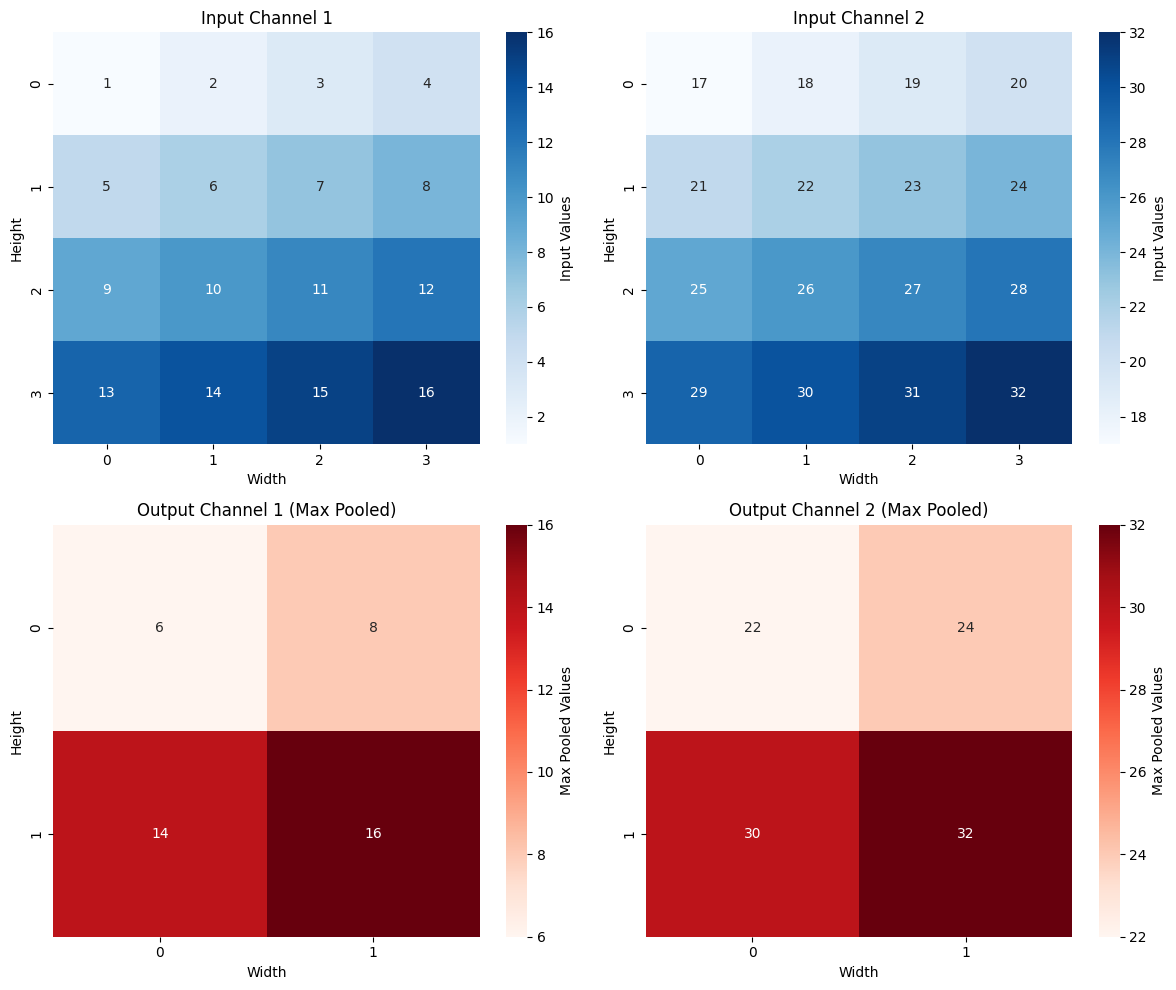


STEP-BY-STEP MAX POOLING PROCESS

Channel 1:
  Window (0,0):
    Input region:
    [1. 2. 5. 6.]
    Max value: 6.0
    Output position (0,0): 6.0

  Window (0,1):
    Input region:
    [3. 4. 7. 8.]
    Max value: 8.0
    Output position (0,1): 8.0

  Window (1,0):
    Input region:
    [ 9. 10. 13. 14.]
    Max value: 14.0
    Output position (1,0): 14.0

  Window (1,1):
    Input region:
    [11. 12. 15. 16.]
    Max value: 16.0
    Output position (1,1): 16.0


Channel 2:
  Window (0,0):
    Input region:
    [17. 18. 21. 22.]
    Max value: 22.0
    Output position (0,0): 22.0

  Window (0,1):
    Input region:
    [19. 20. 23. 24.]
    Max value: 24.0
    Output position (0,1): 24.0

  Window (1,0):
    Input region:
    [25. 26. 29. 30.]
    Max value: 30.0
    Output position (1,0): 30.0

  Window (1,1):
    Input region:
    [27. 28. 31. 32.]
    Max value: 32.0
    Output position (1,1): 32.0



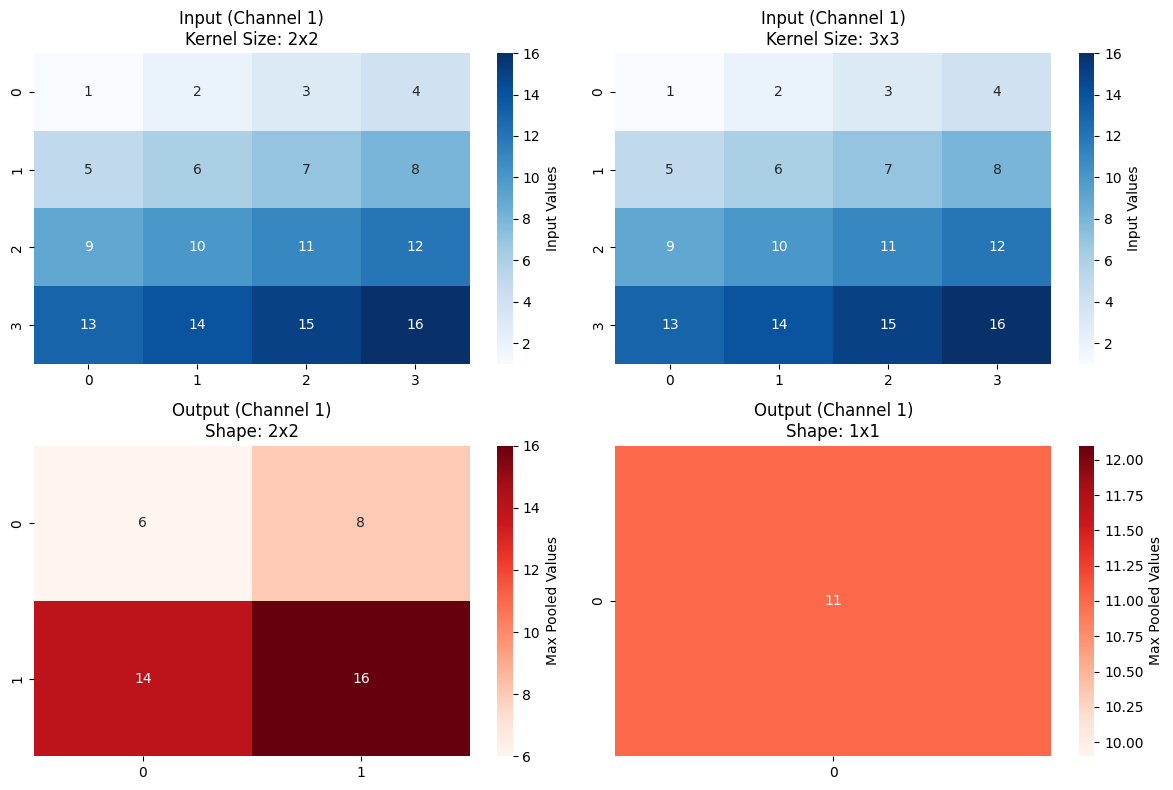


KEY REASONS FOR MAX POOLING
1. DIMENSIONALITY REDUCTION:
   • Reduces spatial dimensions (e.g., 32x32 → 16x16)
   • Decreases computational cost in subsequent layers
   • Reduces memory usage and model parameters

2. TRANSLATION INVARIANCE:
   • Makes the model less sensitive to small shifts in features
   • As shown below, the same pattern produces similar max values
   • Helps with robustness to minor variations in input

3. FEATURE SELECTION:
   • Retains the most prominent features in each window
   • Discards less important information
   • Acts as a form of feature selection

4. OVERFITTING PREVENTION:
   • Reduces model complexity by decreasing spatial dimensions
   • Provides regularization effect by discarding less important features
   • Helps generalize better to unseen data by reducing memorization
   • Acts as a form of feature selection that focuses on dominant patterns

5. RECEPTIVE FIELD GROWTH:
   • Increases the effective receptive field of subsequent layers
   • All

In [15]:
# Manual Max Pooling Toy Example
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from prelu_cnn import ManualMaxPool2d

# Create a simple input tensor (batch_size=1, channels=2, height=4, width=4)
input_tensor = torch.tensor([
    [[[1, 2, 3, 4],
      [5, 6, 7, 8],
      [9, 10, 11, 12],
      [13, 14, 15, 16]],
     
     [[17, 18, 19, 20],
      [21, 22, 23, 24],
      [25, 26, 27, 28],
      [29, 30, 31, 32]]]
], dtype=torch.float32)  # Shape: (1, 2, 4, 4) - batch, channels, height, width

print("Input Tensor Shape:", input_tensor.shape)
print("Input Tensor:")
for c in range(input_tensor.shape[1]):
    print(f"Channel {c+1}:")
    print(input_tensor[0, c].numpy())

# Create ManualMaxPool2d layer with kernel_size=2 and stride=2
maxpool_layer = ManualMaxPool2d(kernel_size=2, stride=2)

# Apply max pooling
output_tensor = maxpool_layer(input_tensor)
print(f"\nOutput Tensor Shape: {output_tensor.shape}")
# Visualize the process
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Input channels
for i in range(2):
    sns.heatmap(input_tensor[0, i].numpy(), annot=True, cmap='Blues', fmt='.0f', 
                ax=axes[0, i], cbar_kws={'label': 'Input Values'})
    axes[0, i].set_title(f'Input Channel {i+1}')
    axes[0, i].set_xlabel('Width')
    axes[0, i].set_ylabel('Height')

# Output channels
for i in range(2):
    sns.heatmap(output_tensor[0, i].numpy(), annot=True, cmap='Reds', fmt='.0f', 
                ax=axes[1, i], cbar_kws={'label': 'Max Pooled Values'})
    axes[1, i].set_title(f'Output Channel {i+1} (Max Pooled)')
    axes[1, i].set_xlabel('Width')
    axes[1, i].set_ylabel('Height')

plt.tight_layout()
plt.show()

# Demonstrate the max pooling process step by step
print("\n" + "="*60)
print("STEP-BY-STEP MAX POOLING PROCESS")
print("="*60)

for channel in range(input_tensor.shape[1]):
    print(f"\nChannel {channel+1}:")
    input_channel = input_tensor[0, channel]
    output_channel = output_tensor[0, channel]
    
    # Show how each 2x2 window is processed
    for i in range(output_channel.shape[0]):
        for j in range(output_channel.shape[1]):
            # Extract the region using the layer's stride
            row_start = i * maxpool_layer.stride
            col_start = j * maxpool_layer.stride
            region = input_channel[row_start:row_start+maxpool_layer.kernel_size, col_start:col_start+maxpool_layer.kernel_size]
            
            print(f"  Window ({i},{j}):")
            print(f"    Input region:")
            print(f"    {region.numpy().flatten()}")
            print(f"    Max value: {region.max().item()}")
            print(f"    Output position ({i},{j}): {output_channel[i,j].item()}")
            print()

kernel_sizes = [2, 3]
fig, axes = plt.subplots(2, len(kernel_sizes), figsize=(12, 8))

for idx, kernel_size in enumerate(kernel_sizes):
    # Create maxpool layer with different kernel size
    maxpool_layer = ManualMaxPool2d(kernel_size=kernel_size, stride=kernel_size)
    output = maxpool_layer(input_tensor)
    
    # Show input
    sns.heatmap(input_tensor[0, 0].numpy(), annot=True, cmap='Blues', fmt='.0f', 
                ax=axes[0, idx], cbar_kws={'label': 'Input Values'})
    axes[0, idx].set_title(f'Input (Channel 1)\nKernel Size: {kernel_size}x{kernel_size}')
    
    # Show output
    sns.heatmap(output[0, 0].numpy(), annot=True, cmap='Reds', fmt='.0f', 
                ax=axes[1, idx], cbar_kws={'label': 'Max Pooled Values'})
    axes[1, idx].set_title(f'Output (Channel 1)\nShape: {output.shape[2]}x{output.shape[3]}')

plt.tight_layout()
plt.show()


print("\n" + "="*60)
print("KEY REASONS FOR MAX POOLING")
print("="*60)

print("1. DIMENSIONALITY REDUCTION:")
print("   • Reduces spatial dimensions (e.g., 32x32 → 16x16)")
print("   • Decreases computational cost in subsequent layers")
print("   • Reduces memory usage and model parameters")

print("\n2. TRANSLATION INVARIANCE:")
print("   • Makes the model less sensitive to small shifts in features")
print("   • As shown below, the same pattern produces similar max values")
print("   • Helps with robustness to minor variations in input")

print("\n3. FEATURE SELECTION:")
print("   • Retains the most prominent features in each window")
print("   • Discards less important information")
print("   • Acts as a form of feature selection")

print("\n4. OVERFITTING PREVENTION:")
print("   • Reduces model complexity by decreasing spatial dimensions")
print("   • Provides regularization effect by discarding less important features")
print("   • Helps generalize better to unseen data by reducing memorization")
print("   • Acts as a form of feature selection that focuses on dominant patterns")

print("\n5. RECEPTIVE FIELD GROWTH:")
print("   • Increases the effective receptive field of subsequent layers")
print("   • Allows higher layers to see larger portions of the input")
print("   • Enables the network to capture more global patterns and relationships")



DEMONSTRATION: TRANSLATION INVARIANCE
Max pooling makes the model less sensitive to small shifts in features


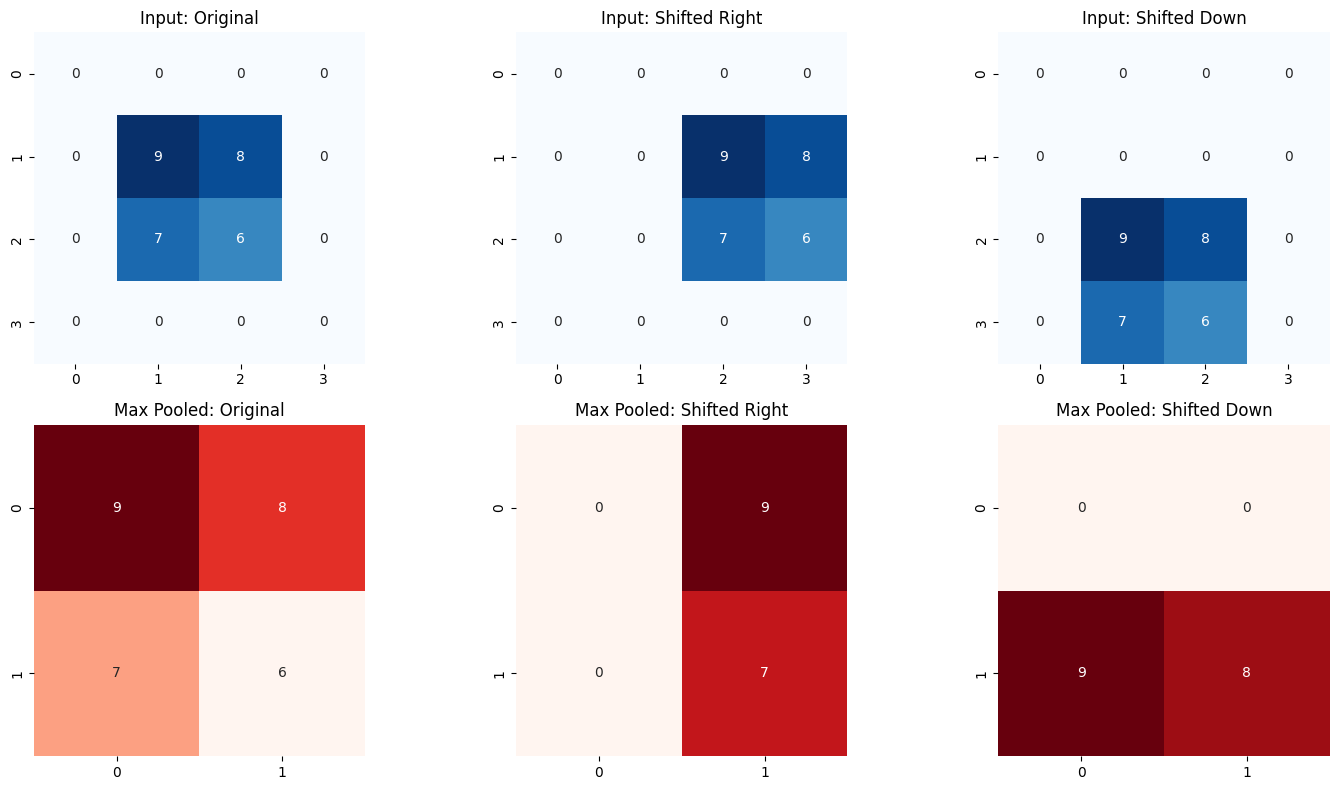

In [17]:
# Demonstration 2: Translation Invariance
print("="*70)
print("DEMONSTRATION: TRANSLATION INVARIANCE")
print("="*70)
print("Max pooling makes the model less sensitive to small shifts in features")

# Create three versions of the same pattern at different positions
pattern_original = torch.tensor([
    [[[0, 0, 0, 0],
      [0, 9, 8, 0],
      [0, 7, 6, 0],
      [0, 0, 0, 0]]]
], dtype=torch.float32)

pattern_shifted_right = torch.tensor([
    [[[0, 0, 0, 0],
      [0, 0, 9, 8],
      [0, 0, 7, 6],
      [0, 0, 0, 0]]]
], dtype=torch.float32)

pattern_shifted_down = torch.tensor([
    [[[0, 0, 0, 0],
      [0, 0, 0, 0],
      [0, 9, 8, 0],
      [0, 7, 6, 0]]]
], dtype=torch.float32)

patterns = [pattern_original, pattern_shifted_right, pattern_shifted_down]
pattern_names = ["Original", "Shifted Right", "Shifted Down"]

# Apply max pooling to each pattern
maxpool_layer = ManualMaxPool2d(kernel_size=2, stride=2)

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for i, (pattern, name) in enumerate(zip(patterns, pattern_names)):
    # Show input pattern
    sns.heatmap(pattern[0, 0].numpy(), annot=True, cmap='Blues', fmt='.0f',
                ax=axes[0, i], cbar=False, square=True)
    axes[0, i].set_title(f'Input: {name}')
    
    # Apply max pooling
    pooled = maxpool_layer(pattern)
    
    # Show pooled output
    sns.heatmap(pooled[0, 0].numpy(), annot=True, cmap='Reds', fmt='.0f',
                ax=axes[1, i], cbar=False, square=True)
    axes[1, i].set_title(f'Max Pooled: {name}')

plt.tight_layout()
plt.show()

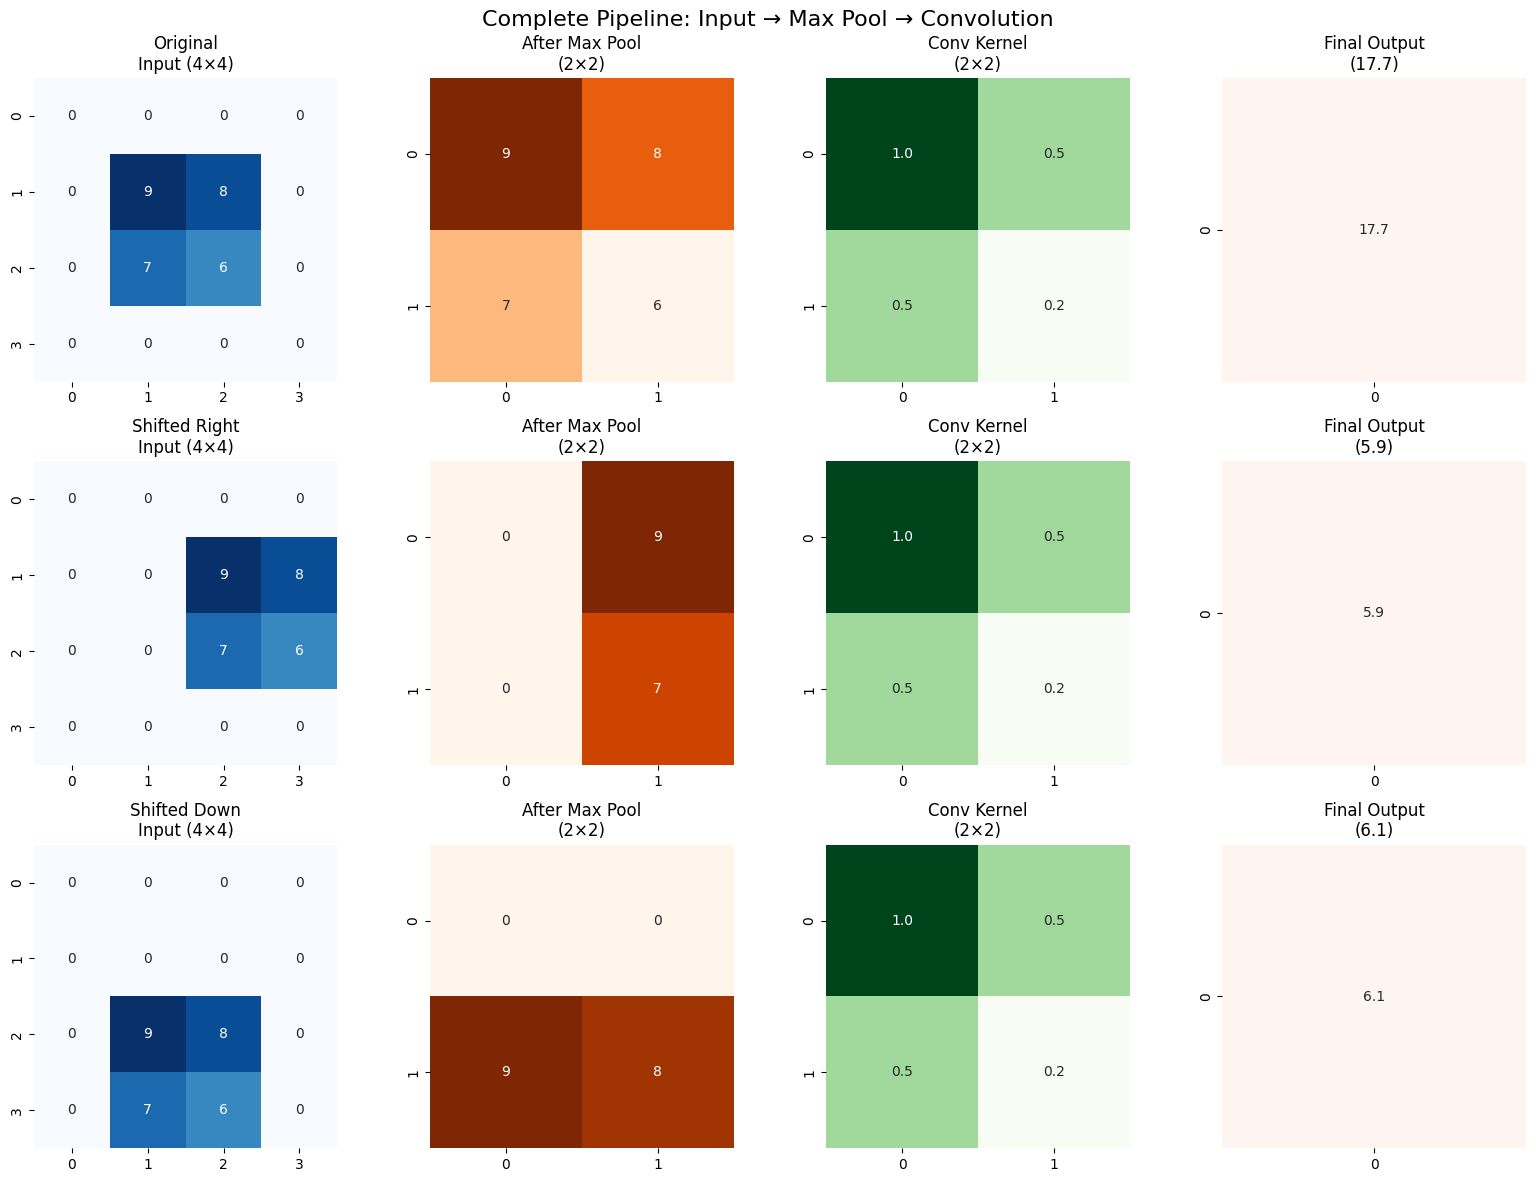

KEY INSIGHTS:
1. MAX POOLING provides LOCAL translation invariance within each pooling window
2. But the POSITION of the max value in the pooled output matters for subsequent layers
3. Different positions → Different convolution results → Different final activations


In [12]:
from prelu_cnn import ManualConv2d

# Use our three pooled outputs from the previous example
patterns = [pattern_original, pattern_shifted_right, pattern_shifted_down]
pattern_names = ["Original", "Shifted Right", "Shifted Down"]
maxpool_layer = ManualMaxPool2d(kernel_size=2, stride=2)

# Create a simple 2x2 convolution kernel that will show the difference
conv_layer = ManualConv2d(in_channels=1, out_channels=1, kernel_size=2, padding=0)

# Set a specific kernel to make the effect clear
with torch.no_grad():
    conv_layer.weight.data = torch.tensor([[[[1.0, 0.5],
                                            [0.5, 0.2]]]])
    conv_layer.bias.data = torch.tensor([0.0])


pooled_outputs = []
conv_outputs = []

for i, (pattern, name) in enumerate(zip(patterns, pattern_names)):
    # Apply max pooling
    pooled = maxpool_layer(pattern)
    pooled_outputs.append(pooled)
    
    # Apply convolution to the pooled output
    conv_output = conv_layer(pooled)
    conv_outputs.append(conv_output)

# Visualize the complete pipeline
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle('Complete Pipeline: Input → Max Pool → Convolution', fontsize=16)

for i, (pattern, pooled, conv_out, name) in enumerate(zip(patterns, pooled_outputs, conv_outputs, pattern_names)):
    # Original input
    sns.heatmap(pattern[0, 0].detach().numpy(), annot=True, cmap='Blues', fmt='.0f',
                ax=axes[i, 0], cbar=False, square=True)
    axes[i, 0].set_title(f'{name}\nInput (4×4)')
    
    # After max pooling
    sns.heatmap(pooled[0, 0].detach().numpy(), annot=True, cmap='Oranges', fmt='.0f',
                ax=axes[i, 1], cbar=False, square=True)
    axes[i, 1].set_title(f'After Max Pool\n(2×2)')
    
    # Convolution kernel (same for all)
    sns.heatmap(conv_layer.weight[0, 0].detach().numpy(), annot=True, cmap='Greens', fmt='.1f',
                ax=axes[i, 2], cbar=False, square=True)
    axes[i, 2].set_title('Conv Kernel\n(2×2)')
    
    # Final output
    sns.heatmap(conv_out[0, 0].detach().numpy(), annot=True, cmap='Reds', fmt='.1f',
                ax=axes[i, 3], cbar=False, square=True)
    axes[i, 3].set_title(f'Final Output\n({conv_out[0, 0, 0, 0].item():.1f})')

plt.tight_layout()
plt.show()

print("KEY INSIGHTS:")
print("="*50)
print("1. MAX POOLING provides LOCAL translation invariance within each pooling window")
print("2. But the POSITION of the max value in the pooled output matters for subsequent layers")
print("3. Different positions → Different convolution results → Different final activations")



DEMONSTRATION 5: HIERARCHICAL FEATURE BUILDING
Each pooling layer increases the receptive field of subsequent layers
Original input shape: torch.Size([1, 1, 8, 8])


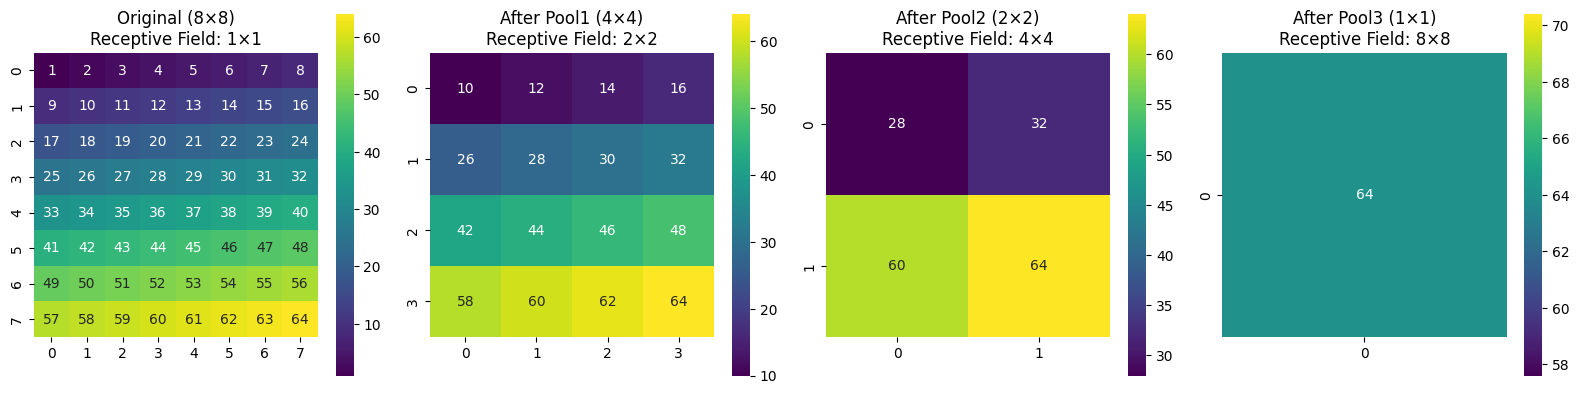


RECEPTIVE FIELD ANALYSIS:
Tracing backward from final output to original input:
• Final output (1×1): Represents entire 8×8 input
• Stage 2 (2×2): Each cell represents 4×4 region of original
• Stage 1 (4×4): Each cell represents 2×2 region of original
• Original (8×8): Each cell represents 1×1 region (itself)

Hierarchical Feature Interpretation:
• Early stages: Fine details (individual pixels)
• Middle stages: Local patterns (edges, textures)
• Later stages: Global features (shapes, objects)
• Final stage: Entire image summary


In [20]:
# Demonstration 5: Hierarchical Feature Building & Receptive Field Growth
print("\n" + "="*70)
print("DEMONSTRATION 5: HIERARCHICAL FEATURE BUILDING")
print("="*70)
print("Each pooling layer increases the receptive field of subsequent layers")

# Create a larger input to demonstrate receptive field growth
large_input = torch.tensor([
    [[[1,  2,  3,  4,  5,  6,  7,  8],
      [9,  10, 11, 12, 13, 14, 15, 16],
      [17, 18, 19, 20, 21, 22, 23, 24],
      [25, 26, 27, 28, 29, 30, 31, 32],
      [33, 34, 35, 36, 37, 38, 39, 40],
      [41, 42, 43, 44, 45, 46, 47, 48],
      [49, 50, 51, 52, 53, 54, 55, 56],
      [57, 58, 59, 60, 61, 62, 63, 64]]]
], dtype=torch.float32)

print(f"Original input shape: {large_input.shape}")

# Apply multiple pooling layers to show hierarchical downsampling
pool1 = ManualMaxPool2d(kernel_size=2, stride=2)
pool2 = ManualMaxPool2d(kernel_size=2, stride=2)
pool3 = ManualMaxPool2d(kernel_size=2, stride=2)

# Progressive pooling
stage1 = pool1(large_input)  # 8x8 -> 4x4
stage2 = pool2(stage1)       # 4x4 -> 2x2
stage3 = pool3(stage2)       # 2x2 -> 1x1

stages = [large_input[0,0], stage1[0,0], stage2[0,0], stage3[0,0]]
stage_names = ["Original (8×8)", "After Pool1 (4×4)", "After Pool2 (2×2)", "After Pool3 (1×1)"]
receptive_fields = ["1×1", "2×2", "4×4", "8×8"]

# Visualize the hierarchical downsampling
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for i, (stage, name, rf) in enumerate(zip(stages, stage_names, receptive_fields)):
    sns.heatmap(stage.numpy(), annot=True, cmap='viridis', fmt='.0f',
                ax=axes[i], cbar=True, square=True)
    axes[i].set_title(f'{name}\nReceptive Field: {rf}')

plt.tight_layout()
plt.show()

# Demonstrate receptive field concept
print("\nRECEPTIVE FIELD ANALYSIS:")
print("="*50)

# Show how one output neuron 'sees' increasingly larger input regions
print("Tracing backward from final output to original input:")
print(f"• Final output (1×1): Represents entire 8×8 input")
print(f"• Stage 2 (2×2): Each cell represents 4×4 region of original")
print(f"• Stage 1 (4×4): Each cell represents 2×2 region of original")
print(f"• Original (8×8): Each cell represents 1×1 region (itself)")

print("\nHierarchical Feature Interpretation:")
print("• Early stages: Fine details (individual pixels)")
print("• Middle stages: Local patterns (edges, textures)")
print("• Later stages: Global features (shapes, objects)")
print("• Final stage: Entire image summary")



Adaptive Average Pooling Debug:
Input: 1 batches × 1 channels × 6×6 spatial
Output: 2×2 spatial

Cell     Row Start  Row End  Col Start  Col End  Region         
----------------------------------------------------------------------
(0,0)   0          3        0          3        [0:3, 0:3]     
    Math: 3×3 region = [1.0, 2.0, 3.0, 2.0, 3.0, 4.0, 3.0, 4.0, 5.0]
    Sum: 27.0, Count: 9, Average: 27.0/9 = 3.0
(0,1)   0          3        3          6        [0:3, 3:6]     
    Math: 3×3 region = [4.0, 5.0, 6.0, 5.0, 6.0, 7.0, 6.0, 7.0, 8.0]
    Sum: 54.0, Count: 9, Average: 54.0/9 = 6.0
(1,0)   3          6        0          3        [3:6, 0:3]     
    Math: 3×3 region = [4.0, 5.0, 6.0, 5.0, 6.0, 7.0, 6.0, 7.0, 8.0]
    Sum: 54.0, Count: 9, Average: 54.0/9 = 6.0
(1,1)   3          6        3          6        [3:6, 3:6]     
    Math: 3×3 region = [7.0, 8.0, 9.0, 8.0, 9.0, 10.0, 9.0, 10.0, 11.0]
    Sum: 81.0, Count: 9, Average: 81.0/9 = 9.0
-------------------------------------------

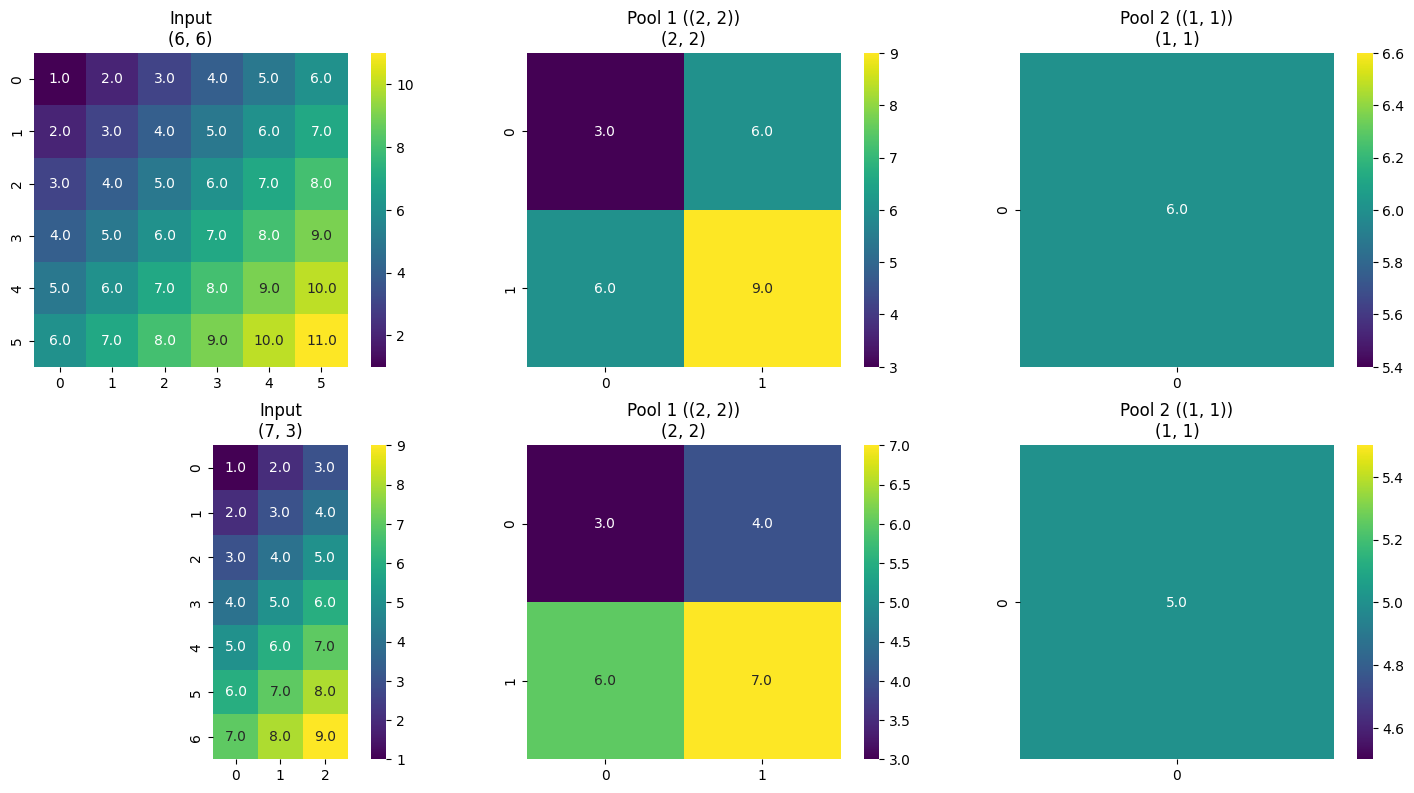

In [3]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Import the ManualAdaptiveAverage class from prelu_cnn
from prelu_cnn import ManualAdaptiveAvgPool2d

# Create a few simple examples including rectangular matrices
test_inputs = [
    # Square 6x6 input
    torch.tensor([[[[1, 2, 3, 4, 5, 6],
                   [2, 3, 4, 5, 6, 7],
                   [3, 4, 5, 6, 7, 8],
                   [4, 5, 6, 7, 8, 9],
                   [5, 6, 7, 8, 9, 10],
                   [6, 7, 8, 9, 10, 11]]]], dtype=torch.float32),
    
    # Rectangular 7x3 input
    torch.tensor([[[[1, 2, 3],
                   [2, 3, 4],
                   [3, 4, 5],
                   [4, 5, 6],
                   [5, 6, 7],
                   [6, 7, 8],
                   [7, 8, 9]]]], dtype=torch.float32),
]

# Create adaptive average pooling layers with different output sizes
adaptive_pools = [
    ManualAdaptiveAvgPool2d(output_size=(2, 2), debug=True),
    ManualAdaptiveAvgPool2d(output_size=(1, 1), debug=True),
]

# Collect all results for side-by-side plotting
all_results = []

# Test each input with each pooling layer
for i, input_tensor in enumerate(test_inputs):
    input_results = []
    input_results.append(("Input", input_tensor[0, 0].numpy()))
    
    for j, pool in enumerate(adaptive_pools):
        output = pool(input_tensor)
        
        # Compare with PyTorch's implementation
        torch_pool = torch.nn.AdaptiveAvgPool2d(pool.output_size)
        torch_output = torch_pool(input_tensor)
        
        # Assert that our implementation matches PyTorch's
        assert torch.allclose(output, torch_output, atol=1e-6), f"Output mismatch for input {i+1}, pool {j+1}"
        
        input_results.append((f"Pool {j+1} ({pool.output_size})", output[0, 0].detach().numpy()))
    
    all_results.append((f"Input {i+1} ({input_tensor.shape})", input_results))

# Plot all examples side by side
fig, axes = plt.subplots(len(test_inputs), len(adaptive_pools) + 1, figsize=(15, 8))

for i, (input_name, results) in enumerate(all_results):
    for j, (result_name, result_data) in enumerate(results):
        sns.heatmap(result_data, annot=True, cmap='viridis', fmt='.1f', 
                   ax=axes[i, j], cbar=True, square=True)
        axes[i, j].set_title(f'{result_name}\n{result_data.shape}')

plt.tight_layout()
plt.show()


Input tensor shape: torch.Size([1, 1, 6, 6])
Input values:
[[ 1.  2.  3.  4.  5.  6.]
 [ 2.  3.  4.  5.  6.  7.]
 [ 3.  4.  5.  6.  7.  8.]
 [ 4.  5.  6.  7.  8.  9.]
 [ 5.  6.  7.  8.  9. 10.]
 [ 6.  7.  8.  9. 10. 11.]]

SPP output shape: torch.Size([1, 50])
SPP output values: [ 1.  2.  3.  4.  5.  6.  2.  3.  4.  5.  6.  7.  3.  4.  5.  6.  7.  8.
  4.  5.  6.  7.  8.  9.  5.  6.  7.  8.  9. 10.  6.  7.  8.  9. 10. 11.
  2.  4.  6.  4.  6.  8.  6.  8. 10.  3.  6.  6.  9.  6.]


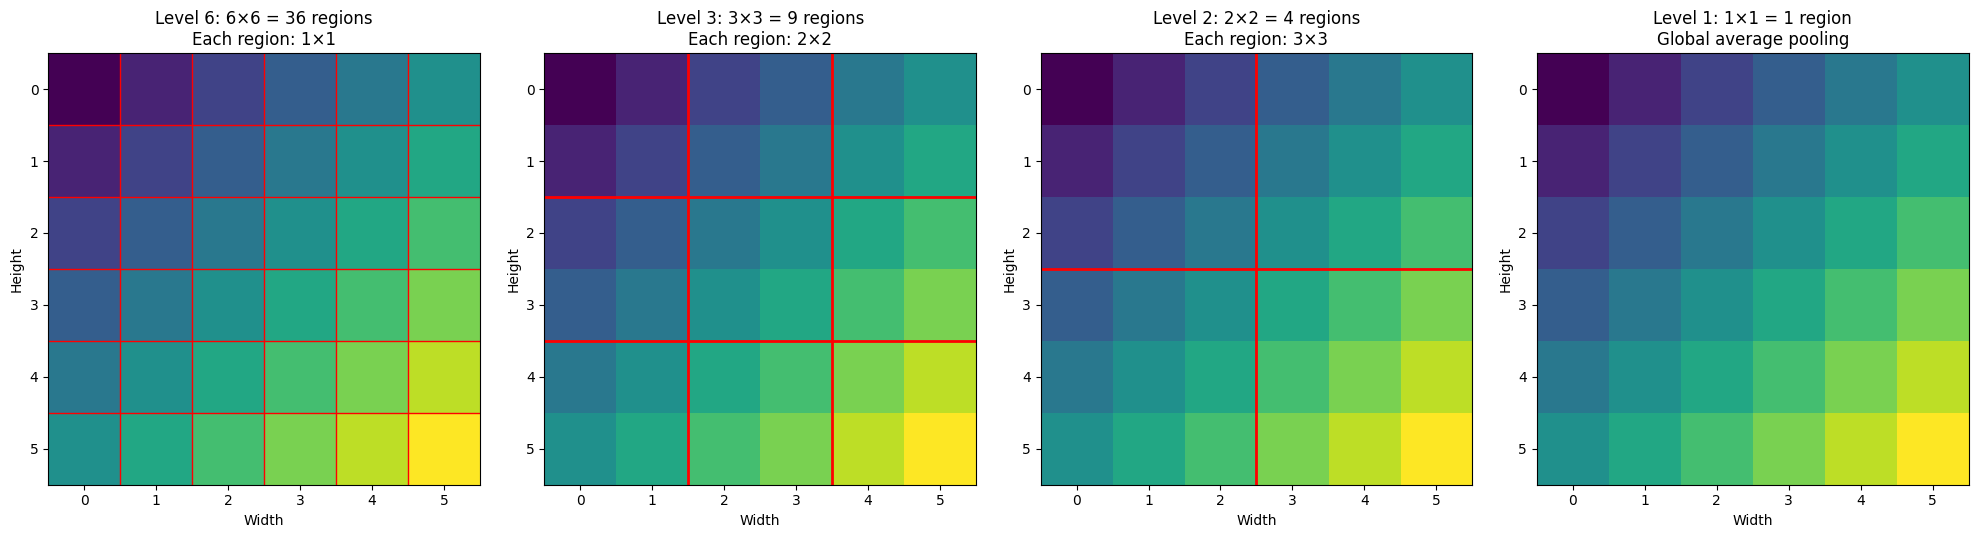

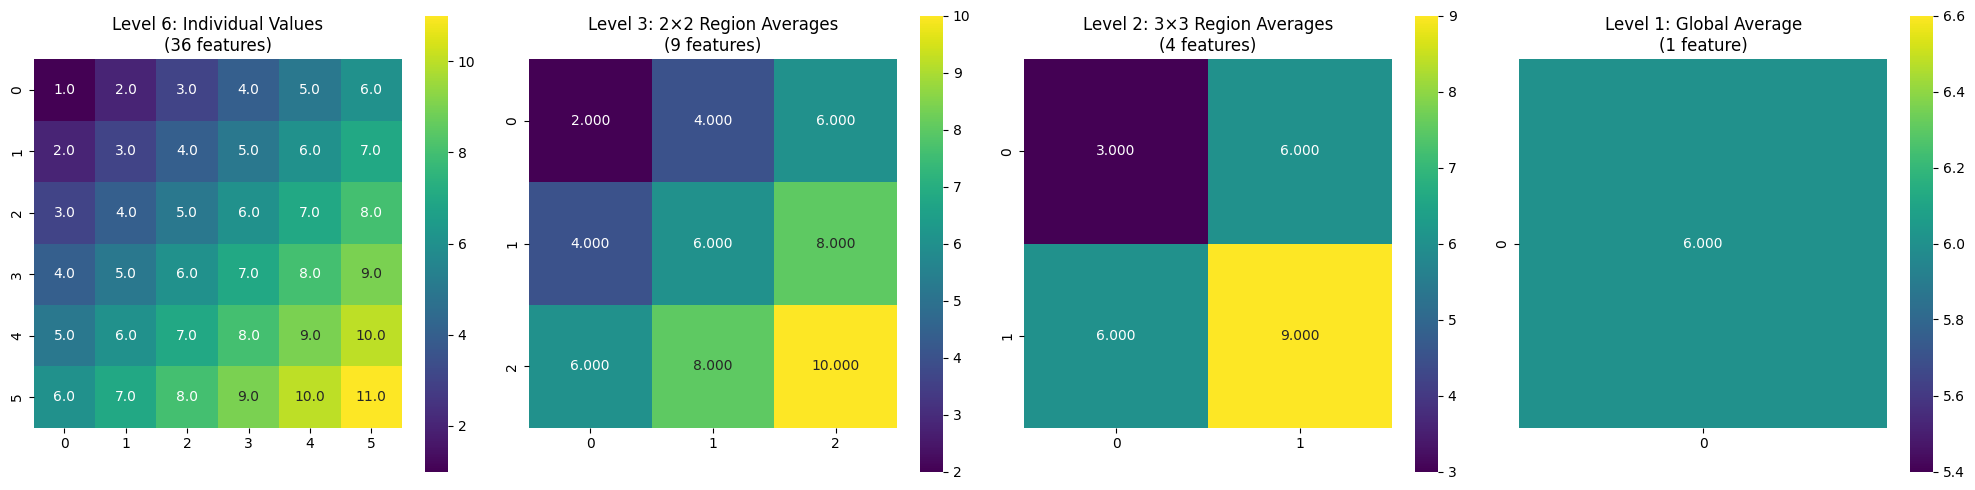


DETAILED MATHEMATICS FOR EACH LEVEL

LEVEL 6 (6×6 = 36 regions):
Each region: 1×1
Region (0,0): [1.]
  Sum: 1.0, Count: 1, Average: 1.000
Region (0,1): [2.]
  Sum: 2.0, Count: 1, Average: 2.000
Region (0,2): [3.]
  Sum: 3.0, Count: 1, Average: 3.000
Region (0,3): [4.]
  Sum: 4.0, Count: 1, Average: 4.000
Region (0,4): [5.]
  Sum: 5.0, Count: 1, Average: 5.000
Region (0,5): [6.]
  Sum: 6.0, Count: 1, Average: 6.000
Region (1,0): [2.]
  Sum: 2.0, Count: 1, Average: 2.000
Region (1,1): [3.]
  Sum: 3.0, Count: 1, Average: 3.000
Region (1,2): [4.]
  Sum: 4.0, Count: 1, Average: 4.000
Region (1,3): [5.]
  Sum: 5.0, Count: 1, Average: 5.000
Region (1,4): [6.]
  Sum: 6.0, Count: 1, Average: 6.000
Region (1,5): [7.]
  Sum: 7.0, Count: 1, Average: 7.000
Region (2,0): [3.]
  Sum: 3.0, Count: 1, Average: 3.000
Region (2,1): [4.]
  Sum: 4.0, Count: 1, Average: 4.000
Region (2,2): [5.]
  Sum: 5.0, Count: 1, Average: 5.000
Region (2,3): [6.]
  Sum: 6.0, Count: 1, Average: 6.000
Region (2,4): [7.]
  

In [13]:
# Test Spatial Pyramid Pooling (SPP) with different levels
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class SpatialPyramidPooling(nn.Module):
    """Spatial Pyramid Pooling layer that pools at multiple scales."""
    
    def __init__(self, levels=[1, 2, 4]):
        super().__init__()
        self.levels = levels
    
    def forward(self, x):
        batch_size, channels, height, width = x.shape
        output = []
        
        for level in self.levels:
            # Calculate bin sizes for this level
            bin_height = height // level
            bin_width = width // level
            
            # Handle remainder by adding extra pixels to some bins
            remainder_h = height % level
            remainder_w = width % level
            
            level_output = []
            
            for i in range(level):
                for j in range(level):
                    # Calculate bin boundaries
                    h_start = i * bin_height
                    h_end = h_start + bin_height + (1 if i < remainder_h else 0)
                    w_start = j * bin_width
                    w_end = w_start + bin_width + (1 if j < remainder_w else 0)
                    
                    # Extract and pool the region
                    region = x[:, :, h_start:h_end, w_start:w_end]
                    pooled = F.adaptive_avg_pool2d(region, (1, 1))  # Global average pooling
                    level_output.append(pooled.flatten(1))  # Flatten spatial dimensions
            
            # Concatenate all bins for this level
            level_features = torch.cat(level_output, dim=1)
            output.append(level_features)
        
        # Concatenate all levels
        return torch.cat(output, dim=1)

# Create test input: 6x6 image
test_input = torch.tensor([
    [[[1, 2, 3, 4, 5, 6],
      [2, 3, 4, 5, 6, 7],
      [3, 4, 5, 6, 7, 8],
      [4, 5, 6, 7, 8, 9],
      [5, 6, 7, 8, 9, 10],
      [6, 7, 8, 9, 10, 11]]]], dtype=torch.float32)

print("Input tensor shape:", test_input.shape)
print("Input values:")
print(test_input[0, 0].numpy())

# Test SPP with levels [6, 3, 2, 1]
spp = SpatialPyramidPooling(levels=[6, 3, 2, 1])
output = spp(test_input)

print(f"\nSPP output shape: {output.shape}")
print(f"SPP output values: {output[0].numpy()}")

# Visualize the pooling regions for each level
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Level 6: 6x6 = 36 regions (1x1 each)
axes[0].imshow(test_input[0, 0].numpy(), cmap='viridis')
axes[0].set_title('Level 6: 6×6 = 36 regions\nEach region: 1×1')
axes[0].set_xlabel('Width')
axes[0].set_ylabel('Height')

# Draw grid lines for level 6
for i in range(1, 6):
    axes[0].axhline(y=i-0.5, color='red', linewidth=1)
    axes[0].axvline(x=i-0.5, color='red', linewidth=1)

# Level 3: 3x3 = 9 regions (2x2 each)
axes[1].imshow(test_input[0, 0].numpy(), cmap='viridis')
axes[1].set_title('Level 3: 3×3 = 9 regions\nEach region: 2×2')
axes[1].set_xlabel('Width')
axes[1].set_ylabel('Height')

# Draw grid lines for level 3
for i in range(1, 6):
    if i % 2 == 0:
        axes[1].axhline(y=i-0.5, color='red', linewidth=2)
        axes[1].axvline(x=i-0.5, color='red', linewidth=2)

# Level 2: 2x2 = 4 regions (3x3 each)
axes[2].imshow(test_input[0, 0].numpy(), cmap='viridis')
axes[2].set_title('Level 2: 2×2 = 4 regions\nEach region: 3×3')
axes[2].set_xlabel('Width')
axes[2].set_ylabel('Height')

# Draw grid lines for level 2
for i in range(1, 6):
    if i % 3 == 0:
        axes[2].axhline(y=i-0.5, color='red', linewidth=2)
        axes[2].axvline(x=i-0.5, color='red', linewidth=2)

# Level 1: 1x1 = 1 region (6x6)
axes[3].imshow(test_input[0, 0].numpy(), cmap='viridis')
axes[3].set_title('Level 1: 1×1 = 1 region\nGlobal average pooling')
axes[3].set_xlabel('Width')
axes[3].set_ylabel('Height')

plt.tight_layout()
plt.show()

# Second visualization: Show the actual pooled values for each level
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Calculate pooled values for each level
input_np = test_input[0, 0].numpy()

# Level 6: Show individual pixel values
level6_values = np.zeros((6, 6))
for i in range(6):
    for j in range(6):
        level6_values[i, j] = input_np[i, j]

sns.heatmap(level6_values, annot=True, cmap='viridis', fmt='.1f', ax=axes[0], cbar=True, square=True)
axes[0].set_title('Level 6: Individual Values\n(36 features)')

# Level 3: Show 2x2 region averages
level3_values = np.zeros((3, 3))
for i in range(3):
    for j in range(3):
        region = input_np[i*2:(i+1)*2, j*2:(j+1)*2]
        level3_values[i, j] = region.mean()

sns.heatmap(level3_values, annot=True, cmap='viridis', fmt='.3f', ax=axes[1], cbar=True, square=True)
axes[1].set_title('Level 3: 2×2 Region Averages\n(9 features)')

# Level 2: Show 3x3 region averages
level2_values = np.zeros((2, 2))
regions_level2 = [
    input_np[0:3, 0:3],  # Top-left
    input_np[0:3, 3:6],  # Top-right
    input_np[3:6, 0:3],  # Bottom-left
    input_np[3:6, 3:6]   # Bottom-right
]

level2_values[0, 0] = regions_level2[0].mean()  # Top-left
level2_values[0, 1] = regions_level2[1].mean()  # Top-right
level2_values[1, 0] = regions_level2[2].mean()  # Bottom-left
level2_values[1, 1] = regions_level2[3].mean()  # Bottom-right

sns.heatmap(level2_values, annot=True, cmap='viridis', fmt='.3f', ax=axes[2], cbar=True, square=True)
axes[2].set_title('Level 2: 3×3 Region Averages\n(4 features)')

# Level 1: Show global average
level1_value = input_np.mean()
level1_values = np.array([[level1_value]])

sns.heatmap(level1_values, annot=True, cmap='viridis', fmt='.3f', ax=axes[3], cbar=True, square=True)
axes[3].set_title('Level 1: Global Average\n(1 feature)')

plt.tight_layout()
plt.show()

# Show detailed math for each level
print("\n" + "="*60)
print("DETAILED MATHEMATICS FOR EACH LEVEL")
print("="*60)

# Level 6 calculation
print("\nLEVEL 6 (6×6 = 36 regions):")
print("Each region: 1×1")
for i in range(6):
    for j in range(6):
        region = test_input[0, 0, i:i+1, j:j+1]
        region_avg = region.mean().item()
        print(f"Region ({i},{j}): {region.flatten().numpy()}")
        print(f"  Sum: {region.sum().item():.1f}, Count: {region.numel()}, Average: {region_avg:.3f}")

# Level 3 calculation
print("\nLEVEL 3 (3×3 = 9 regions):")
print("Each region: 2×2")
regions_level3 = []
for i in range(3):
    for j in range(3):
        region = test_input[0, 0, i*2:(i+1)*2, j*2:(j+1)*2]
        region_avg = region.mean().item()
        regions_level3.append(region)
        print(f"Region ({i},{j}): {region.flatten().numpy()}")
        print(f"  Sum: {region.sum().item():.1f}, Count: {region.numel()}, Average: {region_avg:.3f}")

# Level 2 calculation
print("\nLEVEL 2 (2×2 = 4 regions):")
print("Each region: 3×3")
regions_level2 = [
    test_input[0, 0, 0:3, 0:3],  # Top-left
    test_input[0, 0, 0:3, 3:6],  # Top-right
    test_input[0, 0, 3:6, 0:3],  # Bottom-left
    test_input[0, 0, 3:6, 3:6]   # Bottom-right
]

for i, region in enumerate(regions_level2):
    region_avg = region.mean().item()
    print(f"Region {i+1}: {region.flatten().numpy()}")
    print(f"  Sum: {region.sum().item():.1f}, Count: {region.numel()}, Average: {region_avg:.3f}")

# Level 1 calculation
print("\nLEVEL 1 (1×1 = 1 region):")
print("Input: 6×6 image")
print("Pooling: Global average pooling over entire 6×6 region")
level1_region = test_input[0, 0, :, :]
level1_avg = level1_region.mean().item()
print(f"Values: {level1_region.flatten().numpy()}")
print(f"Sum: {level1_region.sum().item():.1f}")
print(f"Count: {level1_region.numel()}")
print(f"Average: {level1_avg:.3f}")

print(f"\nTotal features: 36 (level 6) + 9 (level 3) + 4 (level 2) + 1 (level 1) = 50 features")
print(f"Output shape: (batch_size, 50)")
